# Bode Diagrams

### First-Order System

In [32]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [33]:
sys = signal.TransferFunction([0.2], [0.2, 1.2,1])
sys1 = signal.TransferFunction([1],[1,1])
sys2 = signal.TransferFunction([1],[0.2,1])
w, mag, phase = signal.bode(sys)
w1, mag1, phase1 = signal.bode(sys1)
w2,mag2, phase2 = signal.bode(sys2)

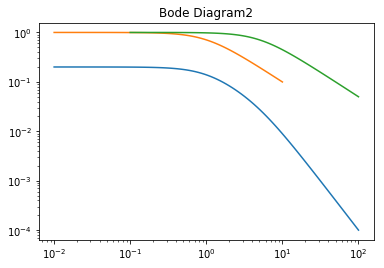

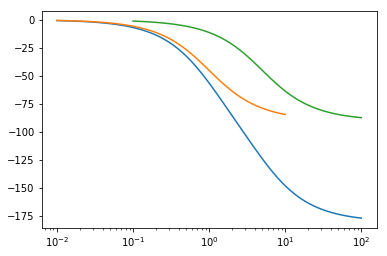

In [34]:
a=2
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
plt.loglog(w1, 10**(mag1/20))
plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.semilogx(w1,phase1)
plt.semilogx(w2,phase2)

### Second-Order System

In [35]:
tau = 1.0
zeta = 0.1

In [36]:
tf = signal.TransferFunction([1.0],[tau**2,2*zeta*tau,1.0])

In [37]:
w, mag, phase = signal.bode(tf)

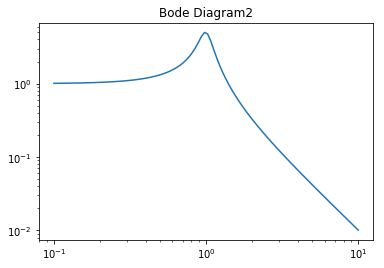

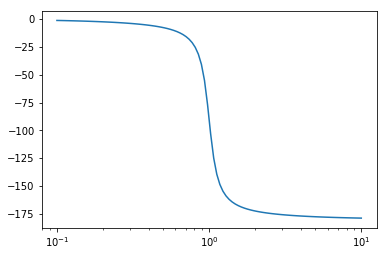

In [38]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

### Proportional-Integral Controller

$G(s) = K_{c}(1+\frac{1}{\tau_{I}s})$

In [39]:
Kc = 1.0
Ti = 0.5
num = [Kc*Ti, Kc]
den = [Ti,0]
tf = signal.TransferFunction(num,den)

In [40]:
w, mag, phase = signal.bode(tf)

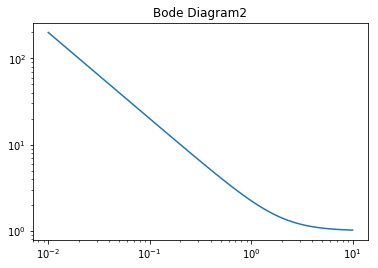

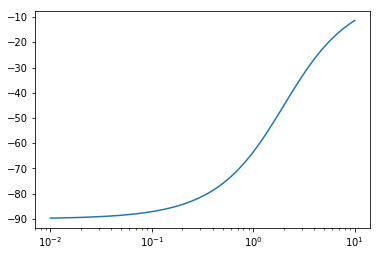

In [41]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

### Proprtional-Derivative Controller

$G(s) = K_{c}(1+\tau_{D}s)$

In [42]:
Kc = 1.0
Td = 0.5
num = [Kc*Td, Kc]
den = [1]
tf = signal.TransferFunction(num,den)

In [43]:
w, mag, phase = signal.bode(tf)

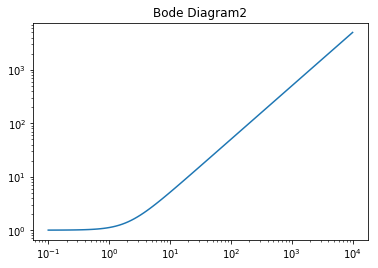

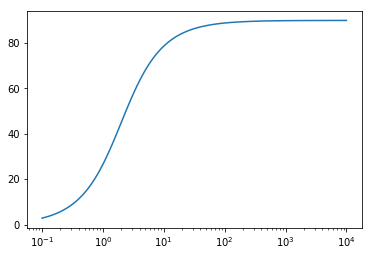

In [44]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

In [45]:
Kc = 10.0
Ti = 0.5
num = [Kc*Ti, Kc]
den = [Ti,0]
tf = signal.TransferFunction(num,den)

In [46]:
w, mag, phase = signal.bode(tf)

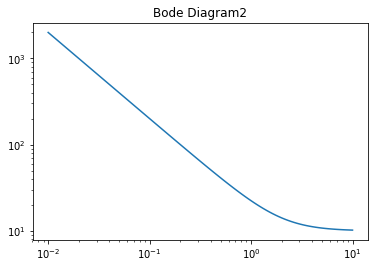

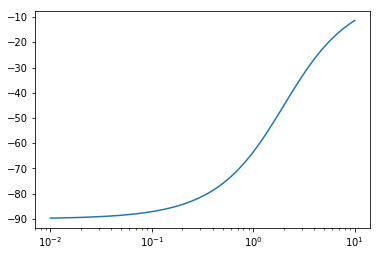

In [47]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

In [48]:
a,b = sys.impulse()

In [49]:
a

array([0.        , 0.07070707, 0.14141414, 0.21212121, 0.28282828,
       0.35353535, 0.42424242, 0.49494949, 0.56565657, 0.63636364,
       0.70707071, 0.77777778, 0.84848485, 0.91919192, 0.98989899,
       1.06060606, 1.13131313, 1.2020202 , 1.27272727, 1.34343434,
       1.41414141, 1.48484848, 1.55555556, 1.62626263, 1.6969697 ,
       1.76767677, 1.83838384, 1.90909091, 1.97979798, 2.05050505,
       2.12121212, 2.19191919, 2.26262626, 2.33333333, 2.4040404 ,
       2.47474747, 2.54545455, 2.61616162, 2.68686869, 2.75757576,
       2.82828283, 2.8989899 , 2.96969697, 3.04040404, 3.11111111,
       3.18181818, 3.25252525, 3.32323232, 3.39393939, 3.46464646,
       3.53535354, 3.60606061, 3.67676768, 3.74747475, 3.81818182,
       3.88888889, 3.95959596, 4.03030303, 4.1010101 , 4.17171717,
       4.24242424, 4.31313131, 4.38383838, 4.45454545, 4.52525253,
       4.5959596 , 4.66666667, 4.73737374, 4.80808081, 4.87878788,
       4.94949495, 5.02020202, 5.09090909, 5.16161616, 5.23232

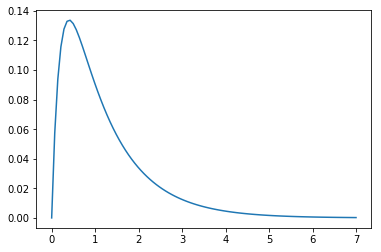

In [50]:
plt.plot(a,b)

In [51]:
c,d = sys.step()

(0, 0.2)

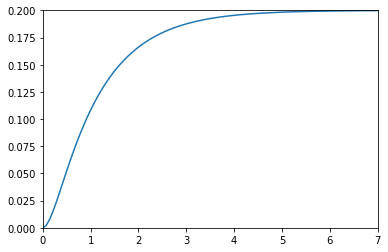

In [52]:
plt.plot(c,d)
plt.xlim(0,7)
plt.ylim(0,0.2)

In [53]:
e,f = sys.impulse()

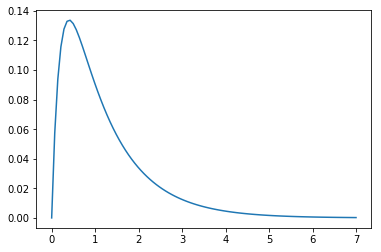

In [54]:

plt.plot(e,f)

In [55]:
sys.poles

array([-5., -1.])

In [56]:
# Import the Jupyter Dashboard related libraries
from ipywidgets import widgets, interact, interactive, interactive_output, FloatSlider
from IPython.display import display

In [70]:
def bode_plt(tau,zeta):
    
    tf = signal.TransferFunction([1.0],[tau**2,2*zeta*tau,1.0])
    
    w, mag, phase = signal.bode(tf)
    
    # Bode magnitude plot
    plt.title('AR vs $\omega$')
    plt.loglog(w, 10**(mag/20), label = r'$\tau$ = '+str(tau)+'; $\zeta$ = '+str(zeta))
    plt.legend(loc='best')
    plt.ylabel('AR')
    plt.grid(b=True)
    plt.figure()
    
    # Bode phase plot
    plt.title('$\phi$ vs $\omega$')
    plt.semilogx(w, phase, label = r'$\tau$ = '+str(tau)+'; $\zeta$ = '+str(zeta))
    plt.xlabel('$\omega$')
    plt.ylabel('$\phi$')
    plt.yticks()
    plt.grid(b=True)
    plt.legend(loc='best')
    
    
    return plt.show()
    
a = interactive(bode_plt, tau=FloatSlider(min=1e-2, max=2.0, step=1e-2,value=1.0), zeta=FloatSlider(min=1e-2, max=2.0, step=1e-2,value=1.0))
display(a)
a.result;

interactive(children=(FloatSlider(value=1.0, description='tau', max=2.0, min=0.01, step=0.01), FloatSlider(val…